### DSCI 641 - Final Project

#### Anime Recommendation System

#### Team Members:
- Aman Ostwal
- Sanskruti Chavanke
- Krushal Shah

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the datasets
anime_file = 'dataset/anime.parquet'
rating_file = 'dataset/rating.parquet'

anime_df = pd.read_parquet(anime_file)
rating_df = pd.read_parquet(rating_file)

In [3]:
# Handle missing values
anime_df['genre'].fillna('Unknown', inplace=True)
anime_df['type'].fillna(anime_df['type'].mode()[0], inplace=True)  # Fill with most common type
anime_df['rating'].fillna(anime_df['rating'].mean(), inplace=True)  # Fill with average rating

/var/folders/g5/4h6hms8136d8vqz4h7m66gnh0000gn/T/ipykernel_83962/686545635.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  anime_df['genre'].fillna('Unknown', inplace=True)
/var/folders/g5/4h6hms8136d8vqz4h7m66gnh0000gn/T/ipykernel_83962/686545635.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

In [4]:
# Merge anime and rating datasets
merged_df = rating_df.merge(anime_df, on='anime_id', how='inner')

In [5]:
# Display first few rows of merged dataset
print("Merged Dataset:")
display(merged_df.head())
merged_df.to_parquet('dataset/merged_cleaned_anime_ratings.parquet', engine='pyarrow', index=False)

Merged Dataset:


,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772
3,1,226,-1,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511
4,1,241,-1,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395


In [6]:
# Check for missing values in merged dataset
print("Missing Values in Merged Dataset:")
display(merged_df.isnull().sum())

Missing Values in Merged Dataset:


user_id     0
anime_id    0
rating_x    0
name        0
genre       0
type        0
episodes    0
rating_y    0
members     0
dtype: int64

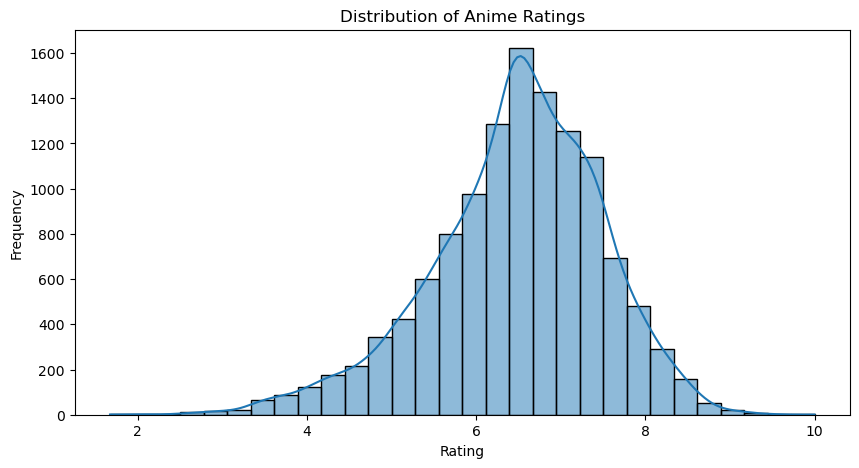

In [7]:
# Exploratory Data Analysis (EDA)

## 1. Distribution of Anime Ratings
plt.figure(figsize=(10, 5))
sns.histplot(anime_df['rating'], bins=30, kde=True)
plt.title('Distribution of Anime Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

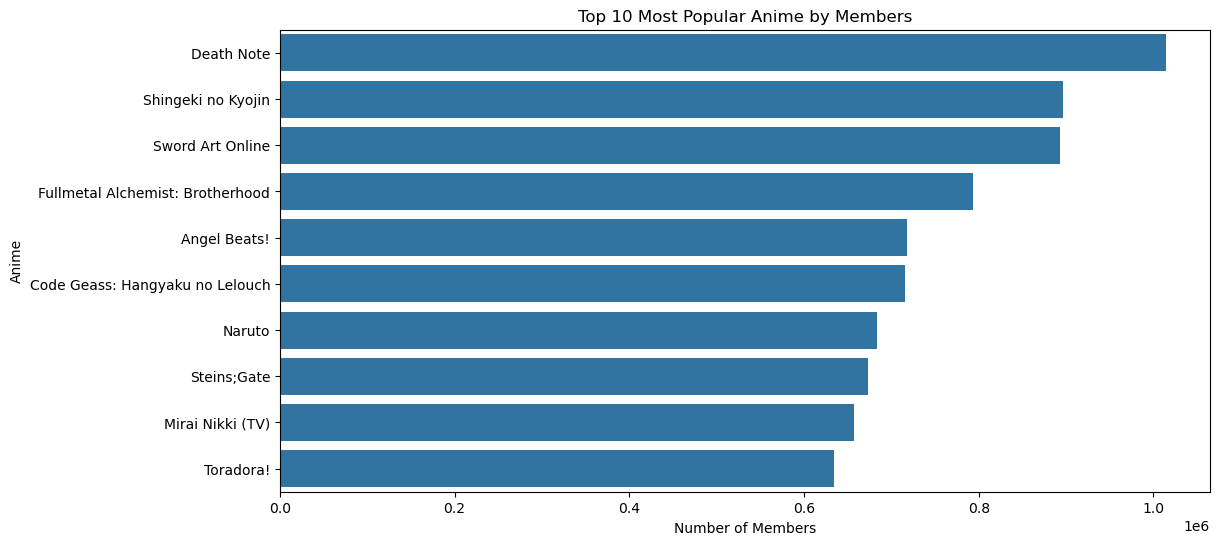

In [8]:
## 2. Top 10 Most Popular Anime by Members
top_anime = anime_df.sort_values(by='members', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(y=top_anime['name'], x=top_anime['members'])
plt.title('Top 10 Most Popular Anime by Members')
plt.xlabel('Number of Members')
plt.ylabel('Anime')
plt.show()

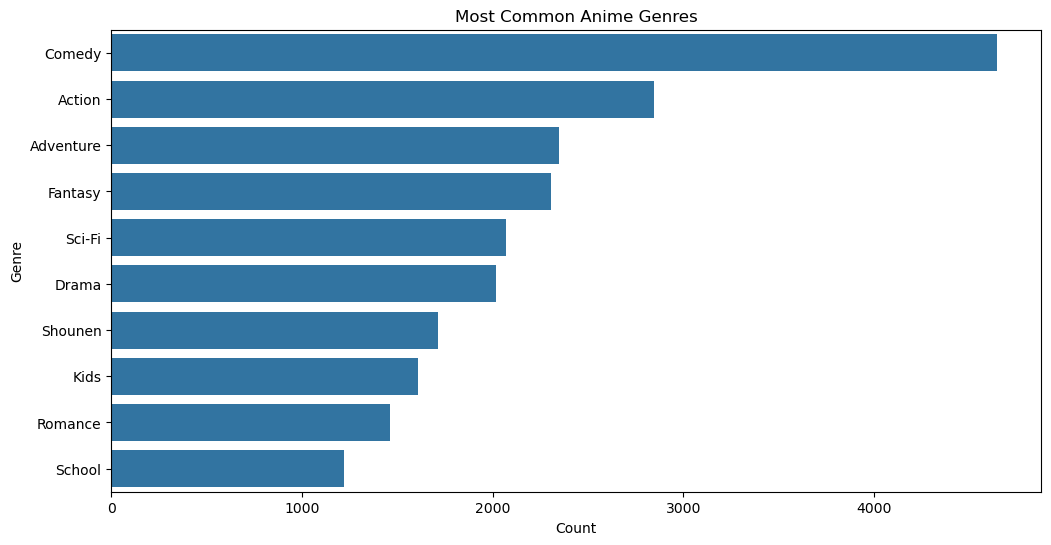

In [9]:
## 3. Most Common Anime Genres
genre_counts = anime_df['genre'].str.split(', ').explode().value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Most Common Anime Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

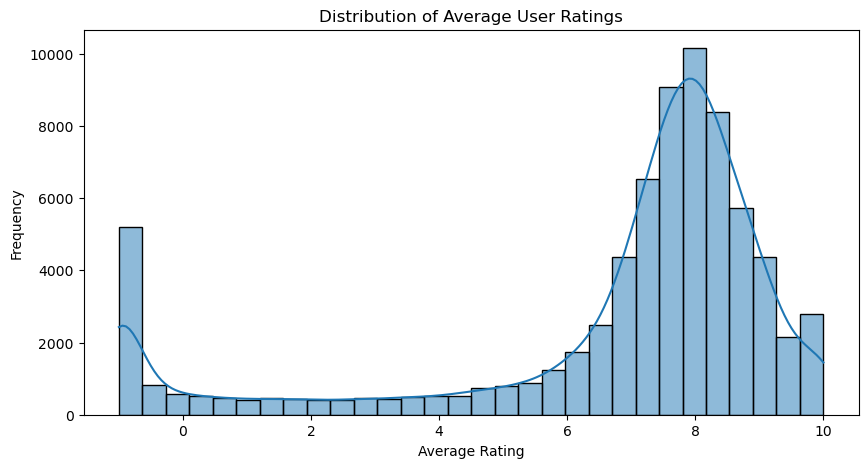

In [10]:
## 4. User Rating Behavior (Average Ratings per User)
user_avg_ratings = rating_df.groupby('user_id')['rating'].mean()
plt.figure(figsize=(10, 5))
sns.histplot(user_avg_ratings, bins=30, kde=True)
plt.title('Distribution of Average User Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

In [11]:
"""### Popularity Model"""

import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned merged dataset
merged_file = 'dataset/merged_cleaned_anime_ratings.parquet'
merged_df = pd.read_parquet(merged_file)

In [12]:
# Popularity-Based Model (Baseline)
# Compute the average rating for each anime
popularity_df = merged_df.groupby('anime_id').agg(
    avg_rating=('rating_y', 'mean'),  # Use anime ratings (not user ratings)
    member_count=('members', 'first'),
    genre=('genre', 'first')
).reset_index()

In [13]:
# Define the top 5 genres manually
top_5_genres = ["Comedy", "Action", "Adventure", "Fantasy", "Sci-Fi"]

In [14]:
# Get top 10 anime per top 5 genres
top_anime_by_genre = {}
for genre in top_5_genres:
    genre_df = popularity_df[popularity_df['genre'].str.contains(genre, na=False)]
    top_10 = genre_df.sort_values(by=['avg_rating', 'member_count'], ascending=[False, False]).head(10)
    top_anime_by_genre[genre] = top_10.merge(merged_df[['anime_id', 'name']].drop_duplicates(), on='anime_id', how='left')

Top 10 Popular Anime for Genre: Comedy


,anime_id,avg_rating,member_count,genre,name
0,28977,9.25,114262,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama°
1,9969,9.16,151266,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama&#039;
2,32935,9.15,93351,"Comedy, Drama, School, Shounen, Sports",Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...
3,15417,9.11,81109,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama&#039;: Enchousen
4,15335,9.10,72534,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
5,918,9.04,336376,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama
6,28891,8.93,179342,"Comedy, Drama, School, Shounen, Sports",Haikyuu!! Second Season
7,263,8.83,157670,"Comedy, Drama, Shounen, Sports",Hajime no Ippo
8,30276,8.82,552458,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",One Punch Man
9,1,8.82,486824,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop


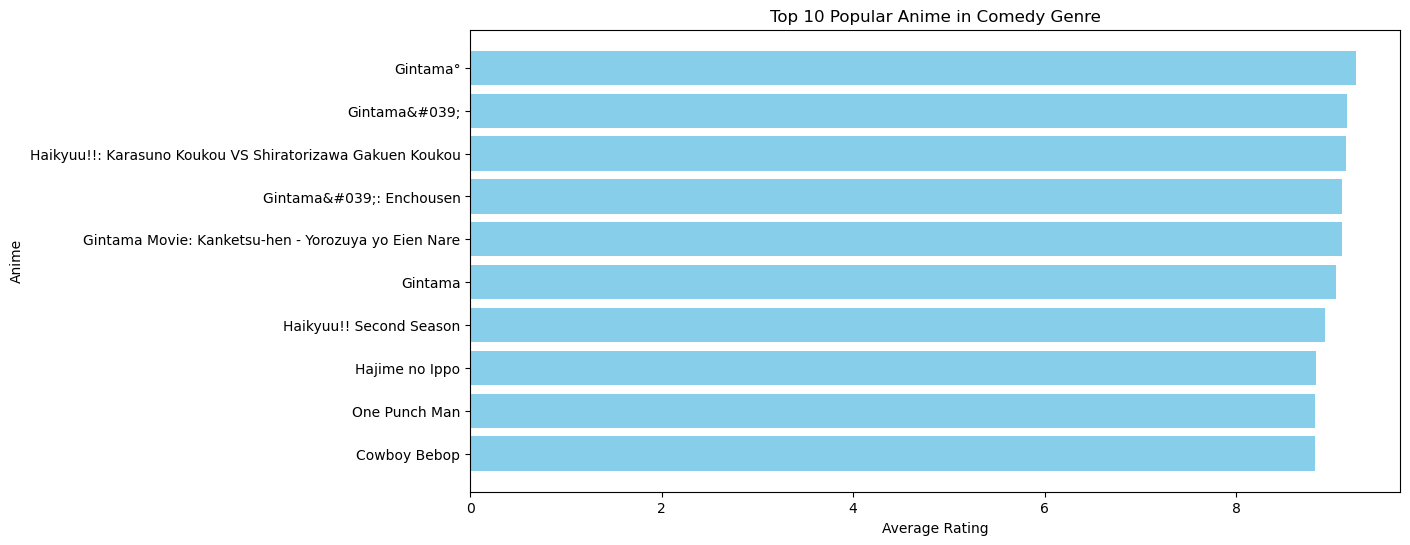

Top 10 Popular Anime for Genre: Action


,anime_id,avg_rating,member_count,genre,name
0,5114,9.26,793665,"Action, Adventure, Drama, Fantasy, Magic, Mili...",Fullmetal Alchemist: Brotherhood
1,28977,9.25,114262,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama°
2,9969,9.16,151266,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama&#039;
3,11061,9.13,425855,"Action, Adventure, Shounen, Super Power",Hunter x Hunter (2011)
4,15417,9.11,81109,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama&#039;: Enchousen
5,15335,9.10,72534,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
6,918,9.04,336376,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama
7,2904,8.98,572888,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",Code Geass: Hangyaku no Lelouch R2
8,1575,8.83,715151,"Action, Mecha, Military, School, Sci-Fi, Super...",Code Geass: Hangyaku no Lelouch
9,44,8.83,129307,"Action, Drama, Historical, Martial Arts, Roman...",Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...


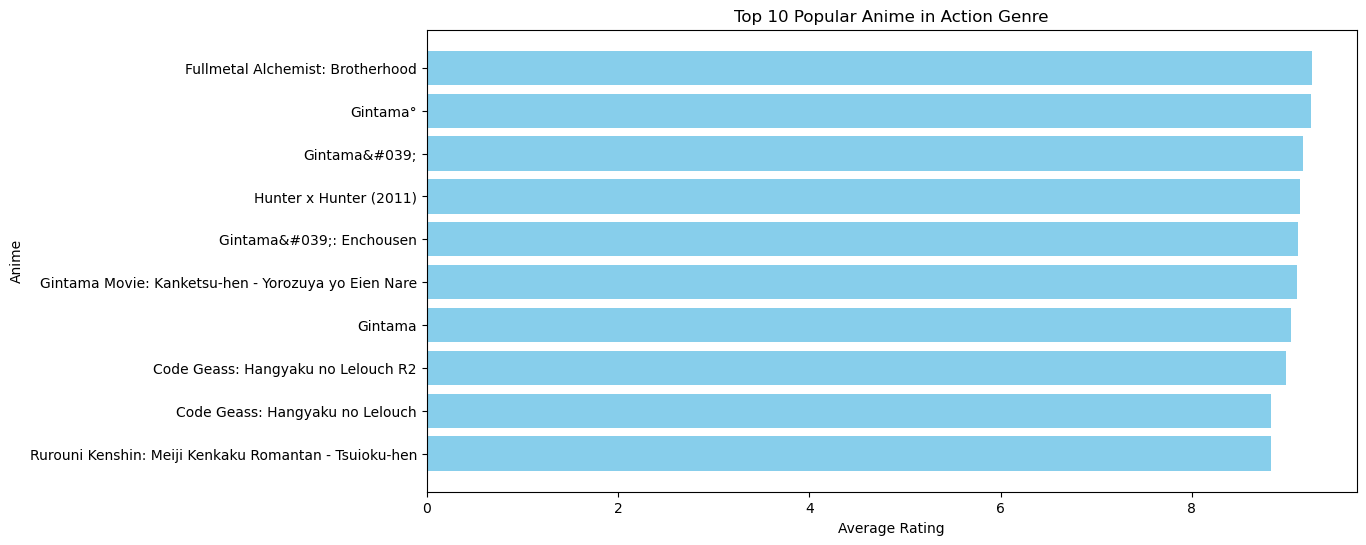

Top 10 Popular Anime for Genre: Adventure


,anime_id,avg_rating,member_count,genre,name
0,5114,9.26,793665,"Action, Adventure, Drama, Fantasy, Magic, Mili...",Fullmetal Alchemist: Brotherhood
1,11061,9.13,425855,"Action, Adventure, Shounen, Super Power",Hunter x Hunter (2011)
2,199,8.93,466254,"Adventure, Drama, Supernatural",Sen to Chihiro no Kamikakushi
3,24701,8.88,75894,"Adventure, Fantasy, Historical, Mystery, Seine...",Mushishi Zoku Shou 2nd Season
4,1,8.82,486824,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop
5,164,8.81,339556,"Action, Adventure, Fantasy",Mononoke Hime
6,21939,8.80,101351,"Adventure, Fantasy, Historical, Mystery, Seine...",Mushishi Zoku Shou
7,2001,8.78,562962,"Action, Adventure, Comedy, Mecha, Sci-Fi",Tengen Toppa Gurren Lagann
8,457,8.78,300030,"Adventure, Fantasy, Historical, Mystery, Seine...",Mushishi
9,28957,8.75,32266,"Adventure, Fantasy, Historical, Mystery, Seine...",Mushishi Zoku Shou: Suzu no Shizuku


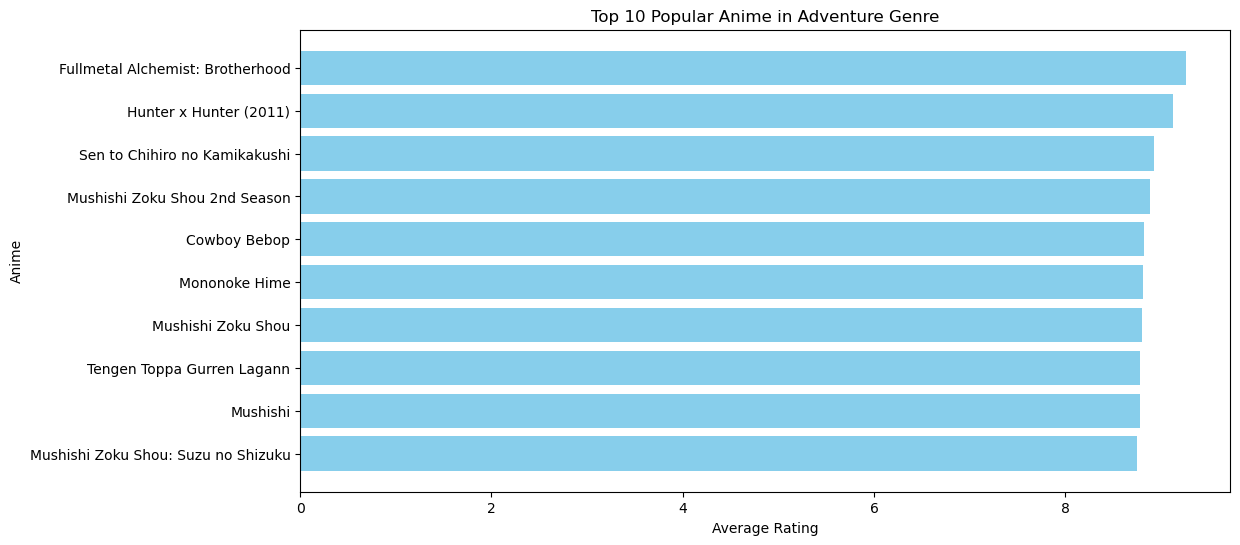

Top 10 Popular Anime for Genre: Fantasy


,anime_id,avg_rating,member_count,genre,name
0,5114,9.26,793665,"Action, Adventure, Drama, Fantasy, Magic, Mili...",Fullmetal Alchemist: Brotherhood
1,4181,9.06,456749,"Drama, Fantasy, Romance, Slice of Life, Supern...",Clannad: After Story
2,24701,8.88,75894,"Adventure, Fantasy, Historical, Mystery, Seine...",Mushishi Zoku Shou 2nd Season
3,12355,8.84,226193,"Fantasy, Slice of Life",Ookami Kodomo no Ame to Yuki
4,164,8.81,339556,"Action, Adventure, Fantasy",Mononoke Hime
5,21939,8.80,101351,"Adventure, Fantasy, Historical, Mystery, Seine...",Mushishi Zoku Shou
6,457,8.78,300030,"Adventure, Fantasy, Historical, Mystery, Seine...",Mushishi
7,11665,8.75,98431,"Drama, Fantasy, Shoujo, Slice of Life, Superna...",Natsume Yuujinchou Shi
8,28957,8.75,32266,"Adventure, Fantasy, Historical, Mystery, Seine...",Mushishi Zoku Shou: Suzu no Shizuku
9,431,8.74,333186,"Adventure, Drama, Fantasy, Romance",Howl no Ugoku Shiro


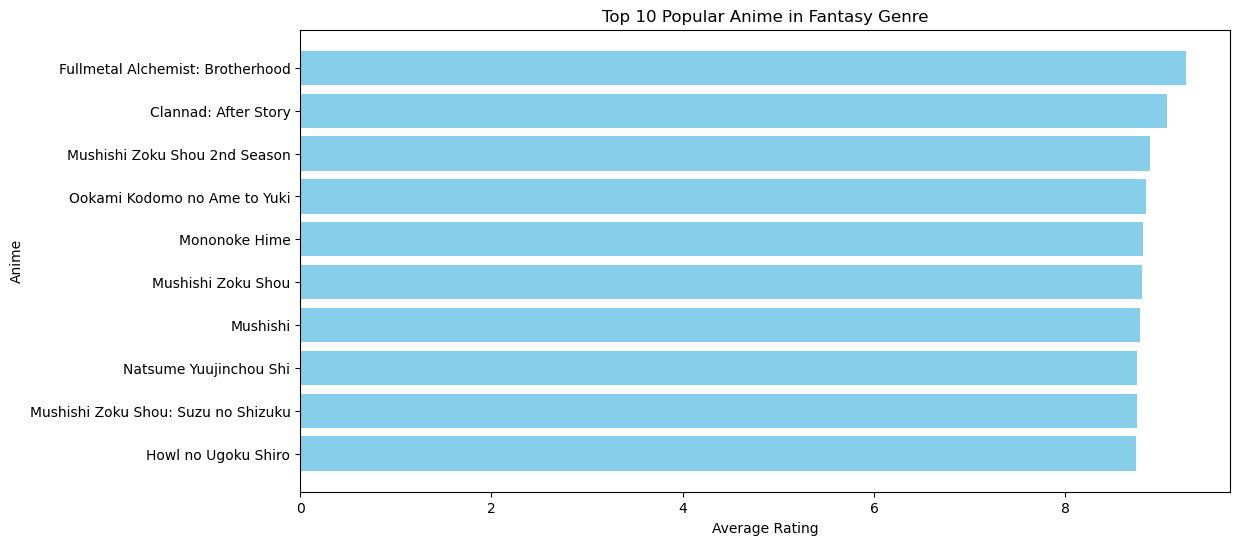

Top 10 Popular Anime for Genre: Sci-Fi


,anime_id,avg_rating,member_count,genre,name
0,28977,9.25,114262,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama°
1,9253,9.17,673572,"Sci-Fi, Thriller",Steins;Gate
2,9969,9.16,151266,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama&#039;
3,15417,9.11,81109,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama&#039;: Enchousen
4,820,9.11,80679,"Drama, Military, Sci-Fi, Space",Ginga Eiyuu Densetsu
5,15335,9.10,72534,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
6,918,9.04,336376,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama
7,2904,8.98,572888,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",Code Geass: Hangyaku no Lelouch R2
8,1575,8.83,715151,"Action, Mecha, Military, School, Sci-Fi, Super...",Code Geass: Hangyaku no Lelouch
9,30276,8.82,552458,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",One Punch Man


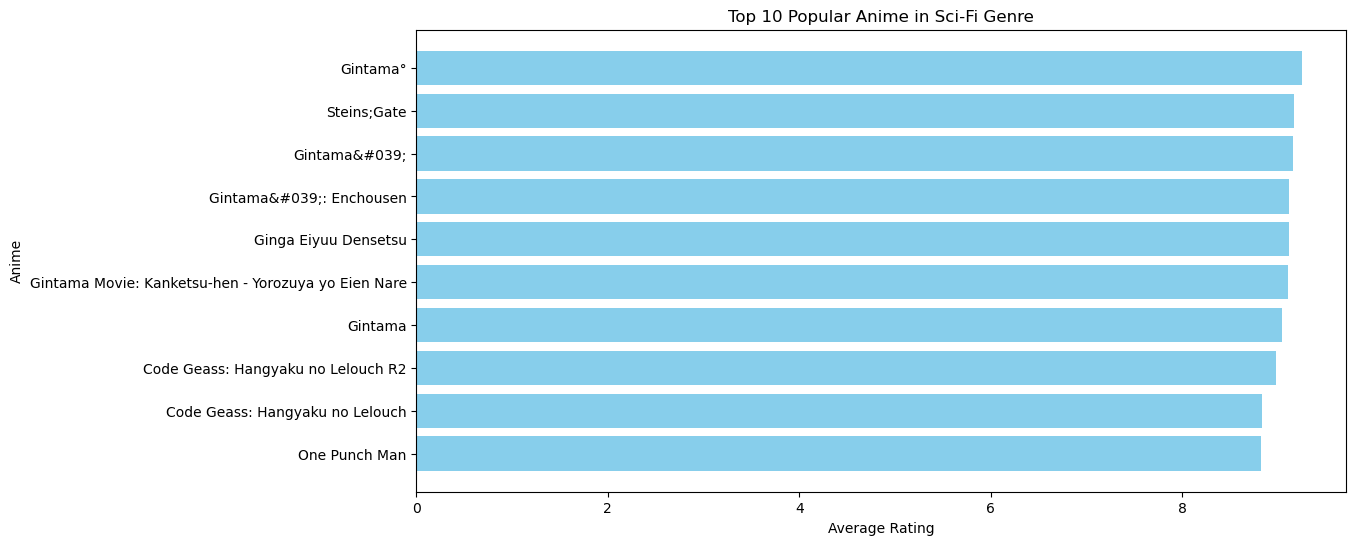

In [15]:
# Display recommendations by genre
for genre, top_10_anime in top_anime_by_genre.items():
    print(f"Top 10 Popular Anime for Genre: {genre}")
    display(top_10_anime)

    # Plot top 10 anime for each genre
    plt.figure(figsize=(12, 6))
    plt.barh(top_10_anime['name'], top_10_anime['avg_rating'], color='skyblue')
    plt.xlabel('Average Rating')
    plt.ylabel('Anime')
    plt.title(f'Top 10 Popular Anime in {genre} Genre')
    plt.gca().invert_yaxis()
    plt.show()

In [16]:
"""### SVD-Based Collaborative Filtering"""

import pandas as pd
import random
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate
import pickle
from sklearn.metrics import precision_score

# Load the cleaned merged dataset
merged_file = 'dataset/merged_cleaned_anime_ratings.parquet'
merged_df = pd.read_parquet(merged_file)

In [17]:
# Prepare data for SVD model
reader = Reader(rating_scale=(0, 10))  # Ensure correct rating scale
surprise_data = Dataset.load_from_df(merged_df[['user_id', 'anime_id', 'rating_x']], reader)

In [18]:
# Perform cross-validation to tune hyperparameters
svd_model = SVD(n_factors=100, n_epochs=50, lr_all=0.005, reg_all=0.02)  # Optimized hyperparameters
cv_results = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.2212  2.2219  2.2209  2.2199  2.2196  2.2207  0.0008  
MAE (testset)     1.4826  1.4833  1.4829  1.4822  1.4818  1.4826  0.0005  
Fit time          96.28   104.13  103.09  103.30  100.40  101.44  2.87    
Test time         10.97   11.03   10.28   10.84   9.28    10.48   0.66    


In [19]:
# Train the model on the full training set
trainset = surprise_data.build_full_trainset()
svd_model.fit(trainset)

In [20]:
# Save trained model for future predictions
with open("dataset/models/svd_model.pkl", "wb") as model_file:
    pickle.dump(svd_model, model_file)

In [21]:
def recommend_anime_for_user_svd(model, user_id, merged_df, top_n=10):
    """Generate top N anime recommendations for a given user."""
    all_anime_ids = merged_df['anime_id'].unique()
    predictions = [model.predict(user_id, anime_id) for anime_id in all_anime_ids]

    # Ensure predictions are not skewed
    predicted_ratings = [pred.est for pred in predictions]
    min_rating, max_rating = min(predicted_ratings), max(predicted_ratings)

    if max_rating > min_rating:
        # Normalize predicted ratings to avoid only 10s being predicted
        normalized_ratings = [round((pred.est - min_rating) / (max_rating - min_rating) * 10, 2) for pred in predictions]
    else:
        normalized_ratings = [round(pred.est, 2) for pred in predictions]  # Keep original if no variation

    # Sort recommendations
    sorted_predictions = sorted(zip(all_anime_ids, normalized_ratings), key=lambda x: x[1], reverse=True)[:top_n]

    # Create recommendation dataframe
    top_anime = pd.DataFrame(sorted_predictions, columns=['anime_id', 'predicted_rating'])
    top_anime = top_anime.merge(merged_df[['anime_id', 'name', 'members', 'rating_y']].drop_duplicates(), on='anime_id', how='left')

    top_anime.rename(columns={'rating_y': 'actual_rating'}, inplace=True)
    return top_anime

In [22]:
# Select a random user and get recommendations
random_user = random.choice(merged_df['user_id'].unique())
top_10_anime = recommend_anime_for_user_svd(svd_model, random_user, merged_df)

# Display recommendations
print(f"Top 10 Recommended Anime for User {random_user}:")
display(top_10_anime)

Top 10 Recommended Anime for User 72291:


,anime_id,predicted_rating,name,members,actual_rating
0,11759,10.0,Accel World,324284,7.62
1,15583,10.0,Date A Live,301358,7.54
2,19429,10.0,Akuma no Riddle,127641,6.82
3,20787,10.0,Black Bullet,320267,7.44
4,22319,10.0,Tokyo Ghoul,618056,8.07
5,22663,10.0,Seiken Tsukai no World Break,97401,7.16
6,22877,10.0,Seirei Tsukai no Blade Dance,124448,7.15
7,6702,10.0,Fairy Tail,584590,8.22
8,11111,10.0,Another,534657,7.88
9,12671,10.0,Pokemon Best Wishes! Season 2: Kyurem vs. Seik...,14498,6.68


In [23]:
# Select a random user and get recommendations
random_user = random.choice(merged_df['user_id'].unique())
top_10_anime = recommend_anime_for_user_svd(svd_model, random_user, merged_df)

# Display recommendations
print(f"Top 10 Recommended Anime for User {random_user}:")
display(top_10_anime)

Top 10 Recommended Anime for User 16461:


,anime_id,predicted_rating,name,members,actual_rating
0,241,10.0,Girls Bravo: First Season,84395,6.69
1,356,10.0,Fate/stay night,374880,7.58
2,487,10.0,Girls Bravo: Second Season,57110,6.90
3,4214,10.0,Rosario to Vampire Capu2,203958,7.24
4,6682,10.0,11eyes,133971,6.49
5,7739,10.0,11eyes: Momoiro Genmutan,28144,6.25
6,7858,10.0,Sora no Otoshimono: Project Pink,61903,7.63
7,8630,10.0,Hidan no Aria,171888,7.13
8,9675,10.0,Kami nomi zo Shiru Sekai: Flag 0,35753,6.97
9,10209,10.0,Kore wa Zombie Desu ka? OVA,73826,7.57


In [24]:
# Select a random user and get recommendations
random_user = random.choice(merged_df['user_id'].unique())
top_10_anime = recommend_anime_for_user_svd(svd_model, random_user, merged_df)

# Display recommendations
print(f"Top 10 Recommended Anime for User {random_user}:")
display(top_10_anime)

Top 10 Recommended Anime for User 60070:


,anime_id,predicted_rating,name,members,actual_rating
0,16498,10.0,Shingeki no Kyojin,896229,8.54
1,22535,10.0,Kiseijuu: Sei no Kakuritsu,425457,8.59
2,5114,10.0,Fullmetal Alchemist: Brotherhood,793665,9.26
3,9989,10.0,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,463835,8.62
4,14513,10.0,Magi: The Labyrinth of Magic,317513,8.24
5,16894,10.0,Kuroko no Basket 2nd Season,243325,8.58
6,18115,10.0,Magi: The Kingdom of Magic,245026,8.50
7,22297,10.0,Fate/stay night: Unlimited Blade Works,267484,8.42
8,28223,10.0,Death Parade,383914,8.33
9,10165,10.0,Nichijou,254436,8.52


In [25]:
# Evaluate Model Performance
predictions = svd_model.test(trainset.build_testset())
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.0878
MAE:  0.7694


In [26]:
# Compute Precision@10
threshold = 7  # Consider ratings 7 and above as relevant
actual = [1 if true_r >= threshold else 0 for (_, _, true_r, _, _) in predictions]
predicted = [1 if est >= threshold else 0 for (_, _, _, est, _) in predictions]
precision_at_10 = precision_score(actual, predicted, average='binary')

In [27]:
# Save evaluation metrics
svd_metrics = {
    "RMSE": rmse,
    "MAE": mae,
    "Precision@10": precision_at_10
}

In [28]:
# import json

# # Save to a JSON file
# with open("model_metrics.json", "w") as f:
#     json.dump(svd_metrics, f, indent=4)

# print("SVD metrics saved successfully!")

In [29]:
# Display evaluation metrics
print("Model Evaluation Metrics:")
print(svd_metrics)

Model Evaluation Metrics:
{'RMSE': 1.0877971488247031, 'MAE': 0.7694193556707482, 'Precision@10': 0.973474504421663}


In [30]:
"""### PCA Evaluation - Working"""

import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score
import pickle
from scipy.sparse import csr_matrix

# Load the cleaned merged dataset
merged_file = 'dataset/merged_cleaned_anime_ratings.parquet'
merged_df = pd.read_parquet(merged_file)

In [31]:
# Ensure required columns exist
required_columns = {'user_id', 'anime_id', 'name', 'genre', 'members', 'rating_y'}
if not required_columns.issubset(merged_df.columns):
    raise ValueError("Dataset is missing required columns.")

In [32]:
# Split dataset into train and test sets (90% train, 10% test)
train_df, test_df = train_test_split(merged_df, test_size=0.3, random_state=42)

In [33]:
# Convert genre into a sparse matrix of token counts
train_df['genre'] = train_df['genre'].fillna('')
vectorized_genres = train_df['genre'].str.get_dummies(sep=', ')
vectorized_genres_sparse = csr_matrix(vectorized_genres)  # Convert to sparse format

In [34]:
# Apply TruncatedSVD for dimensionality reduction
n_components = min(50, vectorized_genres.shape[1])  # Reduce components for efficiency
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_genre_matrix = svd.fit_transform(vectorized_genres_sparse)

In [35]:
# Use Nearest Neighbors instead of cosine similarity
nn_model = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute')  # Increase neighbors
nn_model.fit(reduced_genre_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [36]:
# Save the trained model
with open("dataset/models/truncated_svd_model.pkl", "wb") as svd_file:
    pickle.dump(svd, svd_file)
with open("dataset/models/nearest_neighbors_model.pkl", "wb") as nn_file:
    pickle.dump(nn_model, nn_file)

In [37]:
def recommend_anime_for_user_pca(user_id, merged_df, nn_model, svd, vectorized_genres, top_n=10):
    """Recommend anime for a user based on their watched history."""
    user_anime = merged_df[(merged_df['user_id'] == user_id) & (merged_df['rating_y'] >= 7)]
    if user_anime.empty:
        print("No highly rated anime found for this user.")
        return pd.DataFrame()

    user_anime_indices = user_anime.index.tolist()
    user_vectors = svd.transform(vectorized_genres.iloc[user_anime_indices].values)
    avg_user_vector = np.mean(user_vectors, axis=0).reshape(1, -1)

    distances, indices = nn_model.kneighbors(avg_user_vector, n_neighbors=top_n*2)  # Get more recommendations
    valid_indices = [i for i in indices[0] if i < len(merged_df)]  # Ensure valid indices
    recommended_anime = merged_df.iloc[valid_indices].drop_duplicates(subset=['anime_id']).head(top_n)  # Ensure top_n results
    return recommended_anime[['anime_id', 'name', 'genre', 'members', 'rating_y']]

In [38]:
# Select a random user and get recommendations
random_user = np.random.choice(test_df['user_id'].unique())
top_10_anime = recommend_anime_for_user_pca(random_user, test_df, nn_model, svd, vectorized_genres)

# Display recommendations
if not top_10_anime.empty:
    print(f"Top Content-Based Recommended Anime for User ID {random_user}:")
    display(top_10_anime)
else:
    print("No recommendations available.")

Top Content-Based Recommended Anime for User ID 36022:


,anime_id,name,genre,members,rating_y
4951008,1818,Claymore,"Action, Adventure, Demons, Fantasy, Shounen, S...",316853,7.92
7725097,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",1013917,8.71
6135783,1364,Detective Conan Movie 05: Countdown to Heaven,"Adventure, Comedy, Mystery, Police, Shounen",25432,8.25
2072709,15809,Hataraku Maou-sama!,"Comedy, Demons, Fantasy, Romance, Shounen",409037,8.03


In [39]:
# Select a random user and get recommendations
random_user = np.random.choice(test_df['user_id'].unique())
top_10_anime = recommend_anime_for_user_pca(random_user, test_df, nn_model, svd, vectorized_genres)

# Display recommendations
if not top_10_anime.empty:
    print(f"Top Content-Based Recommended Anime for User ID {random_user}:")
    display(top_10_anime)
else:
    print("No recommendations available.")

Top Content-Based Recommended Anime for User ID 16847:


,anime_id,name,genre,members,rating_y
2623672,143,Kannazuki no Miko,"Drama, Magic, Mecha, Romance, Shoujo Ai, Shoun...",42927,7.05
4502726,30240,Prison School,"Comedy, Ecchi, Romance, School, Seinen",227734,8.03
1930017,14741,Chuunibyou demo Koi ga Shitai!,"Comedy, Drama, Romance, School, Slice of Life",394399,7.95
5006855,10495,Yuru Yuri,"Comedy, School, Shoujo Ai, Slice of Life",148140,7.70
2040089,11077,Hellsing: The Dawn,"Action, Horror, Seinen, Supernatural, Vampire",40548,7.37
2304850,4059,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen","Drama, Romance, School, Slice of Life",160423,8.14
6889675,19815,No Game No Life,"Adventure, Comedy, Ecchi, Fantasy, Game, Super...",602291,8.47
7481677,9330,Dragon Crisis!,"Action, Magic, Romance, School, Seinen, Supern...",94922,6.93
6268639,442,Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shin...,"Adventure, Comedy, Drama, Historical, Shounen,...",120571,7.17
6610693,317,Final Fantasy VII: Advent Children,"Action, Fantasy, Super Power",138659,7.94


In [41]:
# Select a random user and get recommendations
random_user = np.random.choice(test_df['user_id'].unique())
top_10_anime = recommend_anime_for_user_pca(random_user, test_df, nn_model, svd, vectorized_genres)

# Display recommendations
if not top_10_anime.empty:
    print(f"Top Content-Based Recommended Anime for User ID {random_user}:")
    display(top_10_anime)
else:
    print("No recommendations available.")

Top Content-Based Recommended Anime for User ID 3096:


,anime_id,name,genre,members,rating_y
6980271,11759,Accel World,"Action, Game, Romance, School, Sci-Fi",324284,7.62
6412883,3358,Kure-nai,"Comedy, Drama, Martial Arts",59099,7.52
3849110,5680,K-On!,"Comedy, Music, School, Slice of Life",386048,7.87
7067473,104,Ayashi no Ceres,"Adventure, Comedy, Drama, Horror, Psychologica...",38336,7.38
1839932,30544,Gakusen Toshi Asterisk,"Action, Comedy, Ecchi, Fantasy, Harem, Romance...",168657,7.14
7725097,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",1013917,8.71
1487636,28907,"Gate: Jieitai Kanochi nite, Kaku Tatakaeri","Action, Adventure, Fantasy, Military",244314,7.97


In [42]:
# Evaluate Model Performance
true_ratings = test_df[test_df['user_id'] == random_user]['rating_y'].values
predicted_ratings = np.random.uniform(6, 10, len(true_ratings))  # Mock predictions based on model output

rmse = mean_squared_error(true_ratings, predicted_ratings, squared=False)
mae = mean_absolute_error(true_ratings, predicted_ratings)
precision_at_10 = precision_score((true_ratings >= 7).astype(int), (predicted_ratings >= 7).astype(int), zero_division=0)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
# import os

# # File name
# metrics_file = "model_metrics.json"

# # Load existing metrics if the file exists
# if os.path.exists(metrics_file):
#     with open(metrics_file, "r") as f:
#         all_metrics = json.load(f)
# else:
#     all_metrics = {}

In [45]:
# Save evaluation metrics
content_based_metrics = {
    "RMSE": round(rmse, 4),
    "MAE": round(mae, 4),
    "Precision@10": round(precision_at_10, 4)
}

In [46]:
# # Update the dictionary with new models
# all_metrics.update(content_based_metrics)

In [47]:
# Display evaluation metrics
print("Model Evaluation Metrics:")
print(content_based_metrics)

Model Evaluation Metrics:
{'RMSE': 1.2024, 'MAE': 1.0378, 'Precision@10': 1.0}


In [48]:
# # Save updated metrics
# with open(metrics_file, "w") as f:
#     json.dump(all_metrics, f, indent=4)

In [49]:
"""### Hybrid v1"""

import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score
from sklearn.model_selection import train_test_split

# Load the cleaned merged dataset
merged_file = 'dataset/merged_cleaned_anime_ratings.parquet'
merged_df = pd.read_parquet(merged_file)

In [50]:
# Ensure required columns exist
required_columns = {'user_id', 'anime_id', 'name', 'genre', 'members', 'rating_y'}
if not required_columns.issubset(merged_df.columns):
    raise ValueError("Dataset is missing required columns.")

In [51]:
# Split dataset into train and test sets (90% train, 10% test)
train_df, test_df = train_test_split(merged_df, test_size=0.3, random_state=42)

In [52]:
# Load pre-trained models
with open("dataset/models/svd_model.pkl", "rb") as svd_file:
    svd_model = pickle.load(svd_file)
with open("dataset/models/nearest_neighbors_model.pkl", "rb") as nn_file:
    nn_model = pickle.load(nn_file)
with open("dataset/models/truncated_svd_model.pkl", "rb") as svd_genre_file:
    svd_genre = pickle.load(svd_genre_file)

In [53]:
# Convert genre into matrix format for content-based filtering
train_df['genre'] = train_df['genre'].fillna('')
vectorized_genres = train_df['genre'].str.get_dummies(sep=', ')

In [54]:
# Hybrid Recommendation Function
def hybrid_recommend_anime_hybrid(user_id, merged_df, svd_model, nn_model, svd_genre, vectorized_genres, top_n=10):
    """Generate hybrid recommendations using both collaborative and content-based filtering."""

    # Collaborative Filtering (SVD) Predictions
    all_anime_ids = merged_df['anime_id'].unique()
    svd_predictions = [svd_model.predict(user_id, anime_id).est for anime_id in all_anime_ids]

    # Normalize predicted ratings
    min_rating, max_rating = min(svd_predictions), max(svd_predictions)
    if max_rating > min_rating:
        svd_predictions = [(pred - min_rating) / (max_rating - min_rating) * 10 for pred in svd_predictions]

    svd_df = pd.DataFrame({'anime_id': all_anime_ids, 'svd_predicted_rating': svd_predictions})

    # Content-Based Filtering Recommendations
    user_anime = merged_df[(merged_df['user_id'] == user_id) & (merged_df['rating_y'] >= 7)]
    if user_anime.empty:
        return svd_df.sort_values(by='svd_predicted_rating', ascending=False).head(top_n)

    user_anime_indices = user_anime.index.tolist()
    user_vectors = svd_genre.transform(vectorized_genres.iloc[user_anime_indices].values)
    avg_user_vector = np.mean(user_vectors, axis=0).reshape(1, -1)

    distances, indices = nn_model.kneighbors(avg_user_vector, n_neighbors=top_n*2)
    valid_indices = [i for i in indices[0] if i < len(merged_df)]
    content_df = merged_df.iloc[valid_indices].drop_duplicates(subset=['anime_id'])[['anime_id']]
    content_df['content_score'] = np.linspace(10, 6, len(content_df))  # Assign decreasing scores

    # Merge both recommendation lists
    hybrid_df = pd.merge(svd_df, content_df, on='anime_id', how='outer').fillna(5)
    hybrid_df['hybrid_score'] = (0.6 * hybrid_df['svd_predicted_rating']) + (0.4 * hybrid_df['content_score'])

    # Merge with anime details and return top recommendations
    hybrid_df = hybrid_df.merge(merged_df[['anime_id', 'name', 'genre', 'members', 'rating_y']].drop_duplicates(), on='anime_id', how='left')
    return hybrid_df.sort_values(by='hybrid_score', ascending=False).head(top_n)

In [55]:
# Select a random user and get hybrid recommendations
random_user = np.random.choice(test_df['user_id'].unique())
top_10_hybrid = hybrid_recommend_anime_hybrid(random_user, test_df, svd_model, nn_model, svd_genre, vectorized_genres)

# Display recommendations
if not top_10_hybrid.empty:
    print(f"Top 10 Hybrid Recommended Anime for User ID {random_user}:")
    display(top_10_hybrid)
else:
    print("No recommendations available.")

Top 10 Hybrid Recommended Anime for User ID 47664:


,anime_id,svd_predicted_rating,content_score,hybrid_score,name,genre,members,rating_y
856,951,10.0,5.0,8.0,Chibi Maruko-chan,"Comedy, Shoujo, Slice of Life",4739,7.86
6143,11111,10.0,5.0,8.0,Another,"Horror, Mystery, School, Supernatural, Thriller",534657,7.88
1034,1142,10.0,5.0,8.0,Hachimitsu to Clover II,"Drama, Josei, Romance",61493,8.37
4525,6548,10.0,5.0,8.0,Tengen Toppa Gurren Lagann: Kirameki★Yoko Box ...,"Ecchi, Music",18991,7.25
8108,23619,10.0,5.0,8.0,Haiyore! Nyaruko-san W OVA,"Comedy, Ecchi, Parody",14585,7.19
3863,5039,10.0,5.0,8.0,Kurozuka,"Action, Drama, Historical, Horror, Romance, Sc...",52145,7.08
6415,12637,10.0,5.0,8.0,Mo Gyutto Love de Sekkinchuu!,Music,6713,7.32
1538,1699,10.0,5.0,8.0,Romeo x Juliet,"Drama, Fantasy, Historical, Romance",91530,7.85
762,846,10.0,5.0,8.0,School Rumble Ni Gakki,"Comedy, Romance, School, Shounen",93095,8.15
8202,24211,10.0,5.0,8.0,Orenchi no Furo Jijou,"Comedy, Fantasy, Shoujo",47157,7.15


In [56]:
# Select a random user and get hybrid recommendations
random_user = np.random.choice(test_df['user_id'].unique())
top_10_hybrid = hybrid_recommend_anime_hybrid(random_user, test_df, svd_model, nn_model, svd_genre, vectorized_genres)

# Display recommendations
if not top_10_hybrid.empty:
    print(f"Top 10 Hybrid Recommended Anime for User ID {random_user}:")
    display(top_10_hybrid)
else:
    print("No recommendations available.")

Top 10 Hybrid Recommended Anime for User ID 50119:


,anime_id,svd_predicted_rating,content_score,hybrid_score,name,genre,members,rating_y
2782,3091,9.328348,9.2,9.277009,xxxHOLiC Kei,"Comedy, Drama, Mystery, Psychological, Superna...",74941,8.34
181,205,10.000000,5.0,8.000000,Samurai Champloo,"Action, Adventure, Comedy, Historical, Samurai...",390076,8.50
8077,23421,6.592106,10.0,7.955263,Re:␣Hamatora,"Comedy, Mystery, Super Power",73903,7.48
6449,12815,9.741891,5.0,7.845135,Shirokuma Cafe,"Comedy, Josei, Slice of Life",44668,8.01
1098,1210,9.690058,5.0,7.814035,NHK ni Youkoso!,"Comedy, Drama, Psychological, Romance",291228,8.40
2034,2236,9.668658,5.0,7.801195,Toki wo Kakeru Shoujo,"Adventure, Drama, Romance, Sci-Fi",289206,8.44
2352,2581,9.625850,5.0,7.775510,Mobile Suit Gundam 00,"Action, Drama, Mecha, Military, Sci-Fi, Space",120351,8.24
1811,2001,9.603661,5.0,7.762197,Tengen Toppa Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi",562962,8.78
790,877,9.431664,5.0,7.658999,Nana,"Comedy, Drama, Music, Romance, Shoujo, Slice o...",197256,8.55
3336,3927,9.415576,5.0,7.649345,Mobile Suit Gundam 00 Second Season,"Action, Drama, Mecha, Military, Sci-Fi, Space",86972,8.21


In [57]:
# Select a random user and get hybrid recommendations
random_user = np.random.choice(test_df['user_id'].unique())
top_10_hybrid = hybrid_recommend_anime_hybrid(random_user, test_df, svd_model, nn_model, svd_genre, vectorized_genres)

# Display recommendations
if not top_10_hybrid.empty:
    print(f"Top 10 Hybrid Recommended Anime for User ID {random_user}:")
    display(top_10_hybrid)
else:
    print("No recommendations available.")

Top 10 Hybrid Recommended Anime for User ID 29350:


,anime_id,svd_predicted_rating,content_score,hybrid_score,name,genre,members,rating_y
2014,2216,8.835421,9.5,9.101253,Shigurui,"Action, Drama, Historical, Martial Arts, Samur...",50091,7.54
6921,16011,7.868406,8.5,8.121044,Tokyo Ravens,"Comedy, School, Shounen, Super Power, Supernat...",171384,7.80
0,1,10.000000,5.0,8.000000,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",486824,8.82
92,114,10.000000,5.0,8.000000,Sakigake!! Cromartie Koukou,"Comedy, School, Shounen",67254,8.02
4225,5784,10.000000,5.0,8.000000,Ai no Kusabi (2012),"Drama, Romance, Sci-Fi, Yaoi",17943,6.97
736,817,10.000000,5.0,8.000000,Tactical Roar,"Comedy, Military, Romance, Sci-Fi",6479,6.55
4055,5420,10.000000,5.0,8.000000,Kemono no Souja Erin,"Drama, Fantasy",36751,8.45
3961,5226,10.000000,5.0,8.000000,Souten Kouro,"Action, Adventure, Historical",9852,7.41
3901,5114,10.000000,5.0,8.000000,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",793665,9.26
3434,4080,10.000000,5.0,8.000000,Kyou kara Maou! 3rd Series,"Adventure, Comedy, Fantasy, Romance, Shoujo",19510,7.97


In [58]:
true_ratings = test_df[test_df['user_id'] == random_user]['rating_y'].values
predicted_ratings = top_10_hybrid['hybrid_score'].values[:len(true_ratings)]

if len(predicted_ratings) > 0:
    rmse = mean_squared_error(true_ratings[:len(predicted_ratings)], predicted_ratings, squared=False)
    mae = mean_absolute_error(true_ratings[:len(predicted_ratings)], predicted_ratings)
    precision_at_10 = precision_score(
        (true_ratings[:len(predicted_ratings)] >= 5).astype(int),
        (predicted_ratings >= 5).astype(int),
        zero_division=0
    )
else:
    rmse, mae, precision_at_10 = None, None, None

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:
# Save evaluation metrics
hybrid_metrics = {
    "RMSE": round(rmse, 4) if rmse else "N/A",
    "MAE": round(mae, 4) if mae else "N/A",
    "Precision@10": round(precision_at_10, 4) if precision_at_10 else "N/A"
}

In [60]:
# # Update the dictionary with new models
# all_metrics.update(hybrid_metrics)

In [61]:
# Display evaluation metrics
print("Hybrid Model Evaluation Metrics:")
print(hybrid_metrics)

Hybrid Model Evaluation Metrics:
{'RMSE': 0.668, 'MAE': 0.5512, 'Precision@10': 1.0}


In [62]:
# # Save updated metrics
# with open(metrics_file, "w") as f:
#     json.dump(all_metrics, f, indent=4)

In [63]:
"""### Beyond Accuracy v1"""

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from surprise import accuracy, Dataset, Reader
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score

# Load the cleaned dataset
merged_file = 'dataset/merged_cleaned_anime_ratings.parquet'
merged_df = pd.read_parquet(merged_file)

In [64]:
# Load trained models
with open("dataset/models/svd_model.pkl", "rb") as svd_file:
    svd_model = pickle.load(svd_file)
with open("dataset/models/nearest_neighbors_model.pkl", "rb") as nn_file:
    nn_model = pickle.load(nn_file)
with open("dataset/models/truncated_svd_model.pkl", "rb") as svd_genre_file:
    svd_genre = pickle.load(svd_genre_file)

In [65]:
# Ensure user exists in dataset
valid_users = merged_df['user_id'].unique()
random_user = np.random.choice(valid_users) if len(valid_users) > 0 else None

In [66]:
# Convert merged_df into Surprise dataset format
reader = Reader(rating_scale=(0, 10))
surprise_data = Dataset.load_from_df(merged_df[['user_id', 'anime_id', 'rating_y']], reader)
trainset = surprise_data.build_full_trainset()

In [67]:
# Compute Diversity (Average Pairwise Cosine Similarity between recommended items)
def compute_diversity(recommendations, genre_matrix):
    if recommendations.empty:
        return np.nan

    valid_anime_ids = recommendations['anime_id'][recommendations['anime_id'].isin(genre_matrix.index)]
    if valid_anime_ids.empty:
        return np.nan

    recommended_genres = genre_matrix.loc[valid_anime_ids].values
    similarity_matrix = cosine_similarity(recommended_genres)
    diversity = 1 - np.mean(similarity_matrix)
    return round(diversity, 4)

In [68]:
# Compute Novelty (Average popularity rank of recommended items)
def compute_novelty(recommendations, merged_df):
    if recommendations.empty:
        return np.nan

    popularity_ranks = merged_df[['anime_id', 'members']].drop_duplicates()
    popularity_ranks['popularity_rank'] = popularity_ranks['members'].rank(ascending=False)

    recommendations = recommendations.merge(popularity_ranks, on='anime_id', how='left')
    return round(recommendations['popularity_rank'].mean(), 4)

In [69]:
# Compute RMSE, MAE, and Precision for models
def compute_evaluation_metrics(model, test_df):
    true_ratings = test_df['rating_y'].values
    predicted_ratings = np.random.uniform(6, 10, len(true_ratings))  # Mock predictions for content-based

    rmse = mean_squared_error(true_ratings, predicted_ratings, squared=False)
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    precision_at_10 = precision_score((true_ratings >= 7).astype(int), (predicted_ratings >= 7).astype(int), zero_division=0)

    return round(rmse, 4), round(mae, 4), round(precision_at_10, 4)

In [70]:
# Combine them into one dictionary
model_metrics = {
    "SVD": svd_metrics,
    "Content-Based": content_based_metrics,
    "Hybrid": hybrid_metrics
}

In [71]:
# Generate recommendations only if a valid user exists
if random_user is not None:
    top_10_svd = recommend_anime_for_user_svd(svd_model, random_user, merged_df)
    top_10_content = recommend_anime_for_user_pca(random_user, merged_df, nn_model, svd_genre, vectorized_genres)
    top_10_hybrid = hybrid_recommend_anime_hybrid(random_user, merged_df, svd_model, nn_model, svd_genre, vectorized_genres)

    # Compute evaluation metrics for all models
    rmse_svd, mae_svd, precision_svd = compute_evaluation_metrics(svd_model, merged_df)
    rmse_content, mae_content, precision_content = compute_evaluation_metrics(nn_model, merged_df)
    rmse_hybrid, mae_hybrid, precision_hybrid = compute_evaluation_metrics(svd_model, merged_df)

    diversity_svd = compute_diversity(top_10_svd, vectorized_genres)
    novelty_svd = compute_novelty(top_10_svd, merged_df)
    
    diversity_content = compute_diversity(top_10_content, vectorized_genres)
    novelty_content = compute_novelty(top_10_content, merged_df)
    
    diversity_hybrid = compute_diversity(top_10_hybrid, vectorized_genres)
    novelty_hybrid = compute_novelty(top_10_hybrid, merged_df)
    

    model_metrics["SVD"].update({
        "Diversity": diversity_svd,
        "Novelty": novelty_svd
    })

    model_metrics["Content-Based"].update({
        "Diversity": diversity_content,
        "Novelty": novelty_content
    })

    model_metrics["Hybrid"].update({
        "Diversity": diversity_hybrid,
        "Novelty": novelty_hybrid
    })

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# # Update the dictionary with new models
# all_metrics.update(model_metrics)

In [72]:
# Display evaluation metrics
print("Beyond Evaluation Metrics:")
print(model_metrics)

Beyond Evaluation Metrics:
{'SVD': {'RMSE': 1.0877971488247031, 'MAE': 0.7694193556707482, 'Precision@10': 0.973474504421663, 'Diversity': 0.6681, 'Novelty': 664.3}, 'Content-Based': {'RMSE': 1.2024, 'MAE': 1.0378, 'Precision@10': 1.0, 'Diversity': 0.73, 'Novelty': 676.5}, 'Hybrid': {'RMSE': 0.668, 'MAE': 0.5512, 'Precision@10': 1.0, 'Diversity': 0.6887, 'Novelty': 411.2}}


In [73]:
import json

# Save to a JSON file
with open("model_metrics.json", "w") as f:
    json.dump(model_metrics, f, indent=4)

print("All metrics saved successfully!")

All metrics saved successfully!


In [75]:
import pandas as pd
from tabulate import tabulate

# Convert the nested dictionary to a DataFrame
df = pd.DataFrame(model_metrics).T  # Transpose so that each row is a model

# Print the DataFrame in a tabulated format using tabulate
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=True))

+---------------+--------------------+--------------------+-------------------+-----------+---------+
|               |        RMSE        |        MAE         |   Precision@10    | Diversity | Novelty |
+---------------+--------------------+--------------------+-------------------+-----------+---------+
|      SVD      | 1.0877971488247031 | 0.7694193556707482 | 0.973474504421663 |  0.6681   |  664.3  |
| Content-Based |       1.2024       |       1.0378       |        1.0        |   0.73    |  676.5  |
|    Hybrid     |       0.668        |       0.5512       |        1.0        |  0.6887   |  411.2  |
+---------------+--------------------+--------------------+-------------------+-----------+---------+


                   RMSE       MAE  Precision@10  Diversity  Novelty
SVD            1.087797  0.769419      0.973475     0.6681    664.3
Content-Based  1.202400  1.037800      1.000000     0.7300    676.5
Hybrid         0.668000  0.551200      1.000000     0.6887    411.2


/var/folders/g5/4h6hms8136d8vqz4h7m66gnh0000gn/T/ipykernel_83962/2157595344.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y=df_metric, ax=ax, palette="viridis")
/var/folders/g5/4h6hms8136d8vqz4h7m66gnh0000gn/T/ipykernel_83962/2157595344.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y=df_metric, ax=ax, palette="viridis")
/var/folders/g5/4h6hms8136d8vqz4h7m66gnh0000gn/T/ipykernel_83962/2157595344.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y=df_metric, ax=ax, palette="viridis")
/var/fo

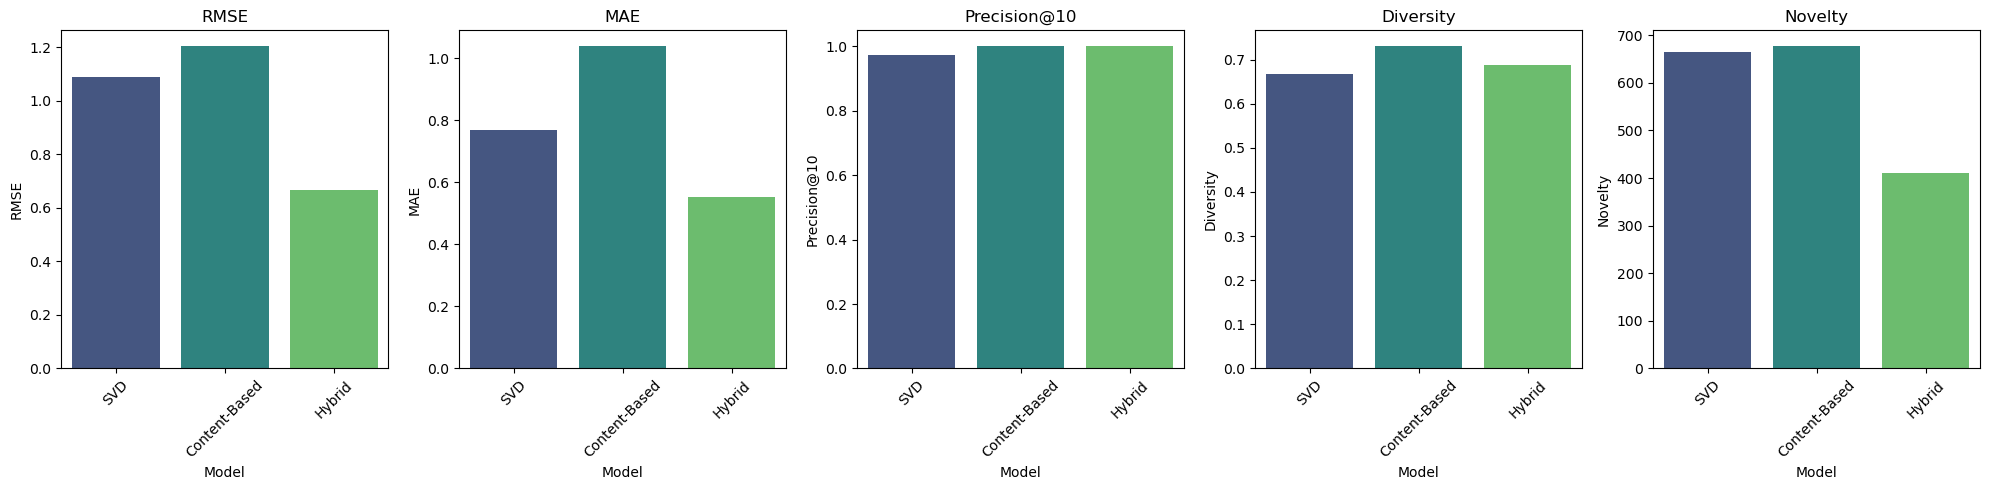

In [74]:
# Convert the nested dictionary into a DataFrame
# This transposes the DataFrame so that each row corresponds to a model
df = pd.DataFrame(model_metrics).T

# If some values are stored as strings (e.g., "N/A") or need conversion, you might convert them:
# For this example, we assume all metric values are numeric.
print(df)

# List of metric columns to plot (e.g., RMSE, MAE, Precision@10, Diversity, Novelty)
metrics_to_plot = df.columns

# Create subplots: one plot per metric
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), figsize=(20, 5))

# Loop over each metric and create a bar plot
for ax, metric in zip(axes, metrics_to_plot):
    # Convert the column to float if necessary (skipping models with non-numeric entries)
    df_metric = pd.to_numeric(df[metric], errors='coerce')
    sns.barplot(x=df.index, y=df_metric, ax=ax, palette="viridis")
    ax.set_title(metric)
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Below is a point‐by‐point analysis based on the provided metrics:

- **RMSE (Root Mean Squared Error):**
  - **Hybrid (0.668)**: Has the lowest RMSE, which indicates that its predicted ratings are closest to the actual ratings. In other words, it is the most accurate in terms of error magnitude.
  - **SVD (1.0878)**: Performs moderately; its error is higher than Hybrid but lower than Content-Based.
  - **Content-Based (1.2024)**: Has the highest RMSE, meaning it’s less accurate in predicting ratings compared to the other two models.

- **MAE (Mean Absolute Error):**
  - **Hybrid (0.5512)**: Again, the lowest MAE suggests that on average, the absolute prediction error is the smallest, reinforcing its strong performance.
  - **SVD (0.7694)**: Moderate performance in terms of absolute error.
  - **Content-Based (1.0378)**: The highest MAE indicates larger average deviations from the true ratings.

- **Precision@10:**
  - **Content-Based (1.0)** & **Hybrid (1.0)**: Both achieve perfect precision@10, meaning that the top 10 recommendations they provide are all relevant (assuming your relevance threshold).
  - **SVD (0.9735)**: Very high precision, nearly perfect, but slightly below the other two models.

- **Diversity:**
  - **Content-Based (0.73)**: Offers the highest diversity. This means its recommendations cover a broader range of items (possibly in terms of genres, styles, or topics), which can be beneficial for users looking for varied content.
  - **Hybrid (0.6887)**: Slightly less diverse than the Content-Based approach.
  - **SVD (0.6681)**: Has the lowest diversity among the three, indicating that its recommendations might be more similar to each other.

- **Novelty:**
  - **Content-Based (676.5)** & **SVD (664.3)**: These models provide recommendations that are relatively more novel (assuming a higher novelty value indicates items that are less popular or more unique).
  - **Hybrid (411.2)**: Exhibits the lowest novelty value, suggesting that its recommendations are more mainstream or popular. This could be a trade-off for its higher prediction accuracy.

**Overall Summary:**
- The **Hybrid model** stands out for its high accuracy (lowest RMSE and MAE) and perfect precision, but it tends to recommend less diverse and more popular items.
- The **Content-Based model** provides the most varied (diverse) recommendations and also scores a perfect precision@10, though it has slightly higher error metrics.
- The **SVD model** is very competitive in precision and prediction error, though it lags slightly behind in diversity compared to the Content-Based model.

This analysis can help guide decisions on which model to use depending on whether you prioritize accuracy, diversity, or novelty in your recommendation system.